In [561]:
### Interested if direct Supervised Learning can solve ODEs45
# Acquire Data from IMU for example acceleration ax,ay,az, time
# Train on Target Data x,y,z,vx,vy,vz
# Test Model

# This time where looking to utilize LSTM models in comparison with DNN 

In [562]:
# Import Modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
from scipy.integrate import solve_ivp
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, r2_score
from matplotlib.animation import FuncAnimation
from ipynb.fs.full.funcCR3BP import CR3BP

In [563]:
# CR3BP Constants (Define System)
mu = 1.215058560962404E-2 
DU = 389703 
TU = 382981

In [564]:
# Load Data
# Data can either be saved and load or solve using Python_IVP Solver
data_output = np.load("TrainData_Artemis.npy").T
time_data = np.load("TrainData_Time.npy")
acceleration_data = np.load("Artemis_Acceleration_Data.npy")

# Concentrate Time and Acceleration Data:
data_input = np.concatenate((time_data.reshape(-1,1), acceleration_data), 1) # Time and Acceleration

# Display Shape
display(data_output.shape) # Rows are the states and columns are time
display(time_data.shape)
display(acceleration_data.shape)
display(data_input.shape)

(878, 6)

(878,)

(878, 3)

(878, 4)

In [565]:
# Data Generated using CR3BP instead of generated data
# Target Inital Conditions (Artemis Orbit)
# Comment Out when needed

# from ipynb.fs.full.funcCR3BP import CR3BP
# # Artemis Orbit Inital Conditions
# targ_IC = np.array([1.023971647162496, 0, -0.183408056849560, 0, -0.107465359472501, 0])
# tend = 1.536808284624788

# sol = solve_ivp(CR3BP, [0, tend], targ_IC, args = (mu,), rtol = 1E-13, atol = 1e-13) # Solve for State of Spacecraft
# x,y,z = sol.y[0:3,:]

# data_output = sol.y.T # Output for Supervised Learning

# time_data = sol.t # Time Data

# # Resolve for acceleration
# idx1 = np.size(x)
# Xa = np.zeros((3, idx1))

# for i in range(idx1):
#     Xdot = CR3BP(1, full_data[i,:], mu)
#     Xa[:,i] = Xdot[3:6] # Acceleration Data

# Xa = Xa.T # Transpose the Data
# print("Time Data shape =", time_data.shape)
# print("Full Output Data =", data_output.shape)
# print("Acceleration Data =", Xa.shape)

# # Time and Acceleration Data can be concentrated if desired model want to train in both acceleration + time: 
# data_input = np.concatenate((time_data.reshape(-1,1), Xa), 1) # Time and Acceleration
# print("Time and AccelerationData =", data_input.shape)

In [566]:
# Train with Different Types of Data: Acceleration Only, Time + Acceleration
# Train with Acceleration Data: 
# Split Data to 70/30 Train Set, needs to be randominize

Xdata, ydata = acceleration_data, data_output
X_train, X_test, y_train, y_test = train_test_split(
    Xdata, ydata,
    test_size=0.30,
    train_size=0.70)

# Display Data
print('X_train shape :', X_train.shape)
print('X_test shape :', X_test.shape)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

X_train shape : (614, 3)
X_test shape : (264, 3)
y_train shape : (614, 6)
y_test shape : (264, 6)


In [567]:
# IF where using LSTM, utilize only acceleration data and set the timestep to be 1
X_train_LSTM = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_LSTM = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train shape :', X_train_LSTM.shape)
print('X_test shape :', X_test_LSTM.shape)

X_train shape : (614, 1, 3)
X_test shape : (264, 1, 3)


In [568]:
# Construct LSTM Model
# Hyperparameters can be fine tuned using Grid Search
# For this case we manuel look at different model types
# Dropout Layers prevent Overfitting
batch_size = X_train.shape[0]
model = Sequential()
model.add(keras.Input(shape = (batch_size, 3)))
model.add(LSTM(units=512, activation='relu', return_sequences = True))
model.add(Dropout(0.2)) 
model.add(LSTM(units=512, activation='relu',return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=512, activation='relu'))
model.add(Dropout(0.2))
# model.add(LSTM(units=512, activation='relu',return_sequences = True))
# model.add(Dropout(0.2))
model.add(Dense(6))
opt = keras.optimizers.Adam(learning_rate = 0.001) # Optimizer = ADAM
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy']) # Mean Squared Error = Loss
model.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 614, 512)       │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 614, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 614, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 614, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,258,246 (20.06 MB)

 Trainable params: 5,258,246 (20.06 MB)

 Non-trainable params: 0 (0.00 B)

In [569]:
history = model.fit(X_train_LSTM, y_train, validation_data = (X_test_LSTM, y_test), epochs = 100, verbose = 3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [570]:
# Predict the Model
y_pred = model.predict(X_test_LSTM) # Predicition
#Summarize the first 100 Cases
#for i in range(100):
    #print('Predicted: '+ str(y_pred[i]) + " => " + 'Expected: ' + str(y_test[i]))
display(y_pred.shape)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


(264, 6)

In [571]:
# Calculate the coefficient of determination. 
R2_Test = r2_score(y_test, y_pred)
print("R2 Score for the Testing Set (Acceleration Model) is:", R2_Test)

R2 Score for the Testing Set (Acceleration Model) is: 0.7375746088196963


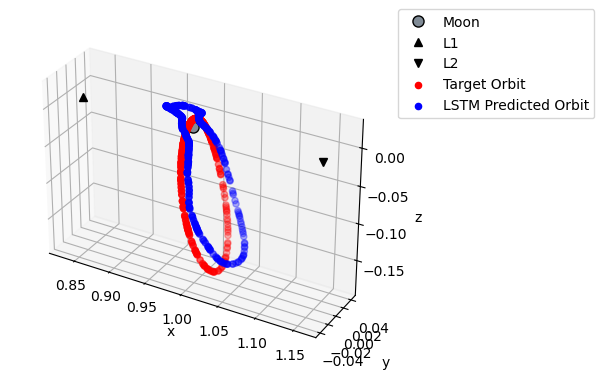

In [572]:
# Graphing 
L1, L2 = [0.83691513, 0, 0], [1.15568217, 0, 0]
fig = plt.figure()
ax = plt.axes(projection = '3d')
    
ax.plot(1-mu, 0, 0, 'o', ms = 8, mec = 'k', mfc = '#808b96', label = 'Moon') # Plotting Moon
ax.plot(L1[0], L1[1], L1[2], '^', color = 'k', label = 'L1') # Plot L1
ax.plot(L2[0], L2[1], L2[2], 'v', color = 'k', label = 'L2') 
ax.scatter(y_test[:,0], y_test[:,1], y_test[:,2], label = 'Target Orbit', color = 'red') # Actual Trajectory 
ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], label = 'LSTM Predicted Orbit', color = 'blue') # Machine Learning Trajectory

# Set Axes Label
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
    
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# If want to save as gif
# angle = 0
# def update(frame): 
#     ax.view_init(30,frame)
#     return fig

# ani = FuncAnimation(fig, update, frames = np.arange(0, 360, 2), interval = 50)
# ani.save("Test1_Epoch100_Neurons512_Layers7.gif", writer ='pillow')

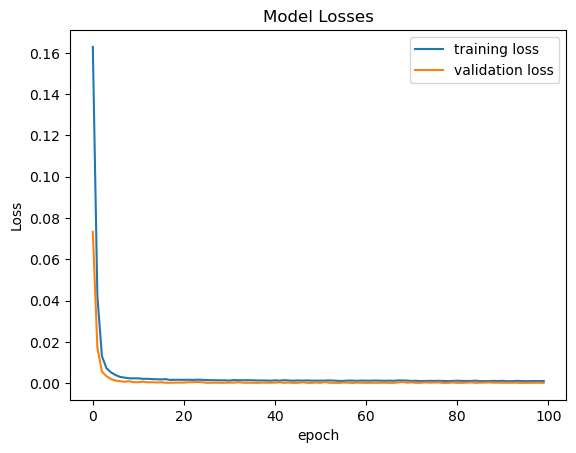

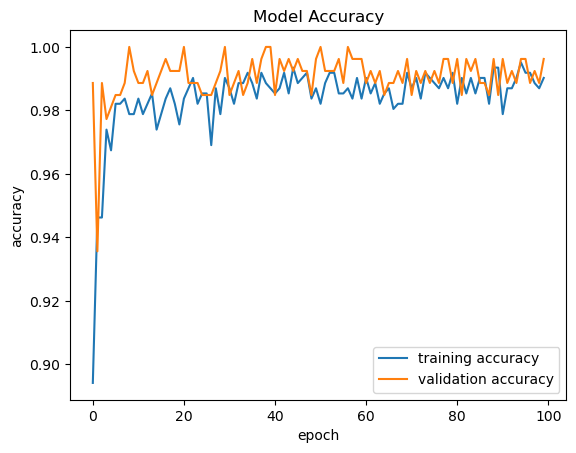

In [573]:
# Plot Validation and Lost Graphs: 
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()